In [1]:
import tensorflow as tf 
import numpy as np 
from tensorflow import keras 
import os 
import math 
import random 
import pickle 
import glob
import matplotlib.pyplot as plt 
from collections import deque 
from tensorflow.keras import layers
import time 
import scipy.io as sio

from vehicle_model_variant import Environment 
from cell_model import CellModel 
from driver_MDP import Driver_MDP 

os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

In [2]:
drving_cycle = '../../OC_SIM_DB/OC_SIM_DB_Cycles/Highway/01_FTP72_fuds.mat'
battery_path = "../../OC_SIM_DB/OC_SIM_DB_Bat/OC_SIM_DB_Bat_nimh_6_240_panasonic_MY01_Prius.mat"
motor_path = "../../OC_SIM_DB/OC_SIM_DB_Mot/OC_SIM_DB_Mot_pm_95_145_X2.mat"
cell_model = CellModel()
# env = Environment(cell_model, drving_cycle, battery_path, motor_path, 10)
driver = Driver_MDP(0.02)

num_states = 4

In [3]:
class OUActionNoise: 
    def __init__(self, mean, std_deviation, theta=0.15, dt=1e-2, x_initial=None): 
        self.theta = theta 
        self.mean = mean 
        self.std_dev = std_deviation 
        self.dt = dt 
        self.x_initial = x_initial 
        self.reset() 
        
    def reset(self): 
        if self.x_initial is not None: 
            self.x_prev = self.x_initial 
        else: 
            self.x_prev = 0 
            
    def __call__(self): 
        x = (
             self.x_prev + self.theta * (self.mean - self.x_prev) * self.dt 
            + self.std_dev * np.sqrt(self.dt) * np.random.normal() 
        )
        self.x_prev = x 
        return x 

In [4]:
class Buffer: 
    def __init__(self, buffer_capacity=100000, batch_size=64):      
        self.buffer_capacity = buffer_capacity 
        self.batch_size = batch_size 
        self.buffer_counter = 0 
        
        self.state_buffer = np.zeros((self.buffer_capacity, num_states))
        self.action_buffer = np.zeros((self.buffer_capacity, 1))
        self.reward_buffer = np.zeros((self.buffer_capacity, 1))
        self.next_state_buffer = np.zeros((self.buffer_capacity, num_states))
        
    def record(self, obs_tuple):
        index = self.buffer_counter % self.buffer_capacity 

        self.state_buffer[index] = obs_tuple[0]
        self.action_buffer[index] = obs_tuple[1]
        self.reward_buffer[index] = obs_tuple[2]
        self.next_state_buffer[index] = obs_tuple[3]
        
        self.buffer_counter += 1 
        
    def learn(self): 
        record_range = min(self.buffer_counter, self.buffer_capacity)
        batch_indices = np.random.choice(record_range, self.batch_size)

        state_batch = tf.convert_to_tensor(self.state_buffer[batch_indices])
        action_batch = tf.convert_to_tensor(self.action_buffer[batch_indices])
        reward_batch = tf.convert_to_tensor(self.reward_buffer[batch_indices])
        reward_batch = tf.cast(reward_batch, dtype=tf.float32)
        next_state_batch = tf.convert_to_tensor(self.next_state_buffer[batch_indices])
        
        with tf.GradientTape() as tape: 
            target_actions = target_actor(next_state_batch)
            y = reward_batch + gamma * target_critic([next_state_batch, target_actions])
            critic_value = critic_model([state_batch, action_batch])
            critic_loss = tf.math.reduce_mean(tf.square(y - critic_value)) 
        critic_grad = tape.gradient(critic_loss, critic_model.trainable_variables) 
        critic_optimizer.apply_gradients(
            zip(critic_grad, critic_model.trainable_variables)
        )
        
        with tf.GradientTape() as tape: 
            actions = actor_model(state_batch)
            critic_value = critic_model([state_batch, actions])
            actor_loss = - tf.math.reduce_mean(critic_value)
        actor_grad = tape.gradient(actor_loss, actor_model.trainable_variables) 
        actor_optimizer.apply_gradients(
            zip(actor_grad, actor_model.trainable_variables)
        )
        

In [5]:
def update_target(tau): 
    new_weights = [] 
    target_variables = target_critic.weights
    for i, variable in enumerate(critic_model.weights): 
        new_weights.append(target_variables[i] * (1 - tau) + tau * variable)
    target_critic.set_weights(new_weights)
    
    new_weights = [] 
    target_variables = target_actor.weights
    for i, variable in enumerate(actor_model.weights): 
        new_weights.append(target_variables[i] * (1 - tau) + tau * variable)
    target_actor.set_weights(new_weights)
    

In [6]:
def get_actor(): 
    last_init = tf.random_uniform_initializer(minval=-0.003, maxval=0.003)
    
    inputs = layers.Input(shape=(num_states))
    inputs_batchnorm = layers.BatchNormalization()(inputs)
    
    out = layers.Dense(512, activation="relu")(inputs_batchnorm)
#     out = layers.BatchNormalization()(out)
    out = layers.Dense(512, activation="relu")(out)
#     out = layers.BatchNormalization()(out)
    outputs = layers.Dense(1, activation="sigmoid", 
                          kernel_initializer=last_init)(out)
    model = tf.keras.Model(inputs, outputs)
    return model

In [7]:
def get_critic(): 
    state_input = layers.Input(shape=(num_states))
    state_input_batchnorm = layers.BatchNormalization()(state_input)
    
    state_out = layers.Dense(16, activation="relu")(state_input_batchnorm)
#     state_out = layers.BatchNormalization()(state_out)
    state_out = layers.Dense(32, activation="relu")(state_out)
#     state_out = layers.BatchNormalization()(state_out)
    
    action_input = layers.Input(shape=(1))
    action_out = layers.Dense(32, activation="relu")(action_input)
#     action_out = layers.BatchNormalization()(action_out)
    
    concat = layers.Concatenate()([state_out, action_out]) 
    
    out = layers.Dense(512, activation="relu")(concat)
#     out = layers.BatchNormalization()(out)
    out = layers.Dense(512, activation="relu")(out)
#     out = layers.BatchNormalization()(out)
    outputs = layers.Dense(1)(out)
    
    model = tf.keras.Model([state_input, action_input], outputs)
    return model 
    

In [8]:
def policy(state, noise_object): 
    j_min = state[0][2].numpy()
    j_max = state[0][3].numpy()
    sampled_action = tf.squeeze(actor_model(state)) 
    noise = noise_object()
    sampled_action = sampled_action.numpy() + noise 
    legal_action = sampled_action * j_max 
    legal_action = np.clip(legal_action, j_min, j_max)
#     print(j_min, j_max, legal_action, noise)
    return legal_action 
    

In [9]:
def policy_epsilon_greedy(state, eps): 
    j_min = state[0][-2].numpy()
    j_max = state[0][-1].numpy()

    if random.random() < eps: 
        a = random.randint(0, 9)
        return np.linspace(j_min, j_max, 10)[a]
    else: 
        sampled_action = tf.squeeze(actor_model(state)).numpy()  
        legal_action = sampled_action * j_max 
        legal_action = np.clip(legal_action, j_min, j_max)
        return legal_action

In [10]:
std_dev = 0.2 
ou_noise = OUActionNoise(mean=0, std_deviation=0.2)

critic_lr = 0.0005 
actor_lr = 0.00025 
critic_optimizer = tf.keras.optimizers.Adam(critic_lr)
actor_optimizer = tf.keras.optimizers.Adam(actor_lr)

total_episodes = 200 
gamma = 0.95 
tau = 0.001 

MAX_EPSILON = 1.0 
MIN_EPSILON = 0.01 
DECAY_RATE = 0.00002
BATCH_SIZE = 32 
DELAY_TRAINING = 3000 

In [11]:
def initialization(): 
    actor_model = get_actor() 
    critic_model = get_critic() 
    target_actor = get_actor() 
    target_critic = get_critic() 
    target_actor.set_weights(actor_model.get_weights())
    target_critic.set_weights(critic_model.get_weights())
#     actor_model.load_weights("./DDPG1_trial1/actor_model_checkpoint")
#     critic_model.load_weights("./DDPG1_trial1/critic_model_checkpoint")
#     target_actor.load_weights("./DDPG1_trial1/target_actor_checkpoint")
#     target_critic.load_weights("./DDPG1_trial1/target_critic_checkpoint")
    
    buffer = Buffer(500000, BATCH_SIZE)
    return actor_model, critic_model, target_actor, target_critic, buffer

In [12]:
def save_weights(actor_model, critic_model, target_actor, target_critic, root): 
    if not os.path.exists(root): 
        os.makedirs(root)
        
    actor_model.save_weights("./{}/actor_model.h5".format(root))
    critic_model.save_weights("./{}/critic_model.h5".format(root))
    target_actor.save_weights("./{}/target_actor.h5".format(root))
    target_critic.save_weights("./{}/target_critic.h5".format(root))
    print("model is saved..")

In [13]:
def initialization_env(driving_path, reward_factor):
    env = Environment(cell_model, driving_path, battery_path, motor_path, reward_factor)
    return env 

In [14]:
def test_agent(actor_model, reward_factor):
    test_cycle = driver.get_cycle() 
    env = initialization_env(test_cycle, reward_factor)
    
    total_reward = 0
    state = env.reset() 
    while True: 
        tf_state = tf.expand_dims(tf.convert_to_tensor(state), 0)
        action = policy_epsilon_greedy(tf_state, -1)
        next_state, reward, done = env.step(action)
        
        state = next_state 
        total_reward += reward 
        
        if done: 
            break 
        
    SOC_deviation_history = np.sum(np.abs(np.array(env.history["SOC"]) - 0.6)) 
    
    print("******************* Test is start *****************")
#     print(test_cycle)
    print('Total reward: {}'.format(total_reward), 
          "SOC: {:.4f}".format(env.SOC), 
          "Cumulative_SOC_deviation: {:.4f}".format(SOC_deviation_history), 
          "Fuel Consumption: {:.4f}".format(env.fuel_consumption))
    print("******************* Test is done *****************")
    print("")
    plt.subplot(1, 2, 1)
    plt.plot(test_cycle)
    plt.subplot(1, 2, 2)
    plt.plot(env.history["Action"])
    plt.show() 
    return env.history  
    


Trial 0

../data/driving_cycles/city\01_FTP72_fuds.mat
maximum steps, simulation is done ... 
elapsed_time: 13.707
Episode: 1 Exploration P: 1.0000 Total reward: -5126.4573750330965 SOC: 1.0000 Cumulative_SOC_deviation: 497.9206 Fuel Consumption: 147.2513

../data/driving_cycles/city\06_udds_truck.mat
maximum steps, simulation is done ... 
elapsed_time: 14.649
Episode: 2 Exploration P: 1.0000 Total reward: -3896.8351820929297 SOC: 1.0000 Cumulative_SOC_deviation: 377.5372 Fuel Consumption: 121.4637

../data/driving_cycles/city\07_manhattan.mat

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing auto

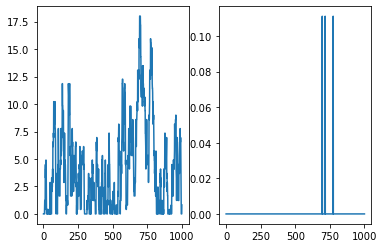

../data/driving_cycles/city\01_FTP72_fuds.mat
maximum steps, simulation is done ... 
elapsed_time: 85.145
Episode: 11 Exploration P: 0.7990 Total reward: -4847.713437240019 SOC: 1.0000 Cumulative_SOC_deviation: 472.8094 Fuel Consumption: 119.6193

../data/driving_cycles/city\06_udds_truck.mat
maximum steps, simulation is done ... 
elapsed_time: 66.695
Episode: 12 Exploration P: 0.7824 Total reward: -3631.7463719566204 SOC: 1.0000 Cumulative_SOC_deviation: 353.3302 Fuel Consumption: 98.4439

../data/driving_cycles/city\07_manhattan.mat
maximum steps, simulation is done ... 
elapsed_time: 68.446
Episode: 13 Exploration P: 0.7657 Total reward: -3830.6712339415703 SOC: 1.0000 Cumulative_SOC_deviation: 374.3680 Fuel Consumption: 86.9910

../data/driving_cycles/city\FTP_75_cycle.mat
maximum steps, simulation is done ... 
elapsed_time: 118.169
Episode: 14 Exploration P: 0.7379 Total reward: -6768.33544808082 SOC: 1.0000 Cumulative_SOC_deviation: 660.8131 Fuel Consumption: 160.2048

../data/dr

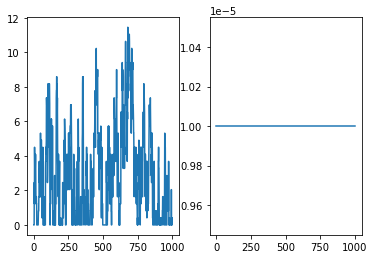

../data/driving_cycles/city\01_FTP72_fuds.mat
maximum steps, simulation is done ... 
elapsed_time: 86.448
Episode: 21 Exploration P: 0.6186 Total reward: -4256.046304065709 SOC: 1.0000 Cumulative_SOC_deviation: 415.4896 Fuel Consumption: 101.1499

../data/driving_cycles/city\06_udds_truck.mat
maximum steps, simulation is done ... 
elapsed_time: 66.662
Episode: 22 Exploration P: 0.6058 Total reward: -3322.512294270125 SOC: 1.0000 Cumulative_SOC_deviation: 323.8390 Fuel Consumption: 84.1223

../data/driving_cycles/city\07_manhattan.mat
maximum steps, simulation is done ... 
elapsed_time: 68.666
Episode: 23 Exploration P: 0.5930 Total reward: -3661.9111570486098 SOC: 1.0000 Cumulative_SOC_deviation: 359.0573 Fuel Consumption: 71.3384

../data/driving_cycles/city\FTP_75_cycle.mat
maximum steps, simulation is done ... 
elapsed_time: 118.315
Episode: 24 Exploration P: 0.5715 Total reward: -5863.756164865842 SOC: 1.0000 Cumulative_SOC_deviation: 573.6043 Fuel Consumption: 127.7130

../data/dr

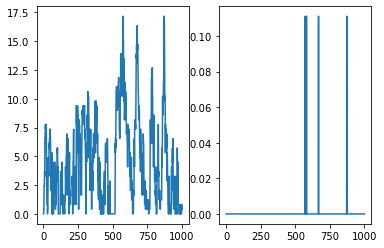

../data/driving_cycles/city\01_FTP72_fuds.mat
maximum steps, simulation is done ... 
elapsed_time: 86.599
Episode: 31 Exploration P: 0.4795 Total reward: -2811.413022413291 SOC: 1.0000 Cumulative_SOC_deviation: 272.5874 Fuel Consumption: 85.5385

../data/driving_cycles/city\06_udds_truck.mat
maximum steps, simulation is done ... 
elapsed_time: 66.297
Episode: 32 Exploration P: 0.4696 Total reward: -2903.2942752824065 SOC: 1.0000 Cumulative_SOC_deviation: 282.8438 Fuel Consumption: 74.8566

../data/driving_cycles/city\07_manhattan.mat
maximum steps, simulation is done ... 
elapsed_time: 69.528
Episode: 33 Exploration P: 0.4597 Total reward: -3287.5001948858608 SOC: 1.0000 Cumulative_SOC_deviation: 323.2217 Fuel Consumption: 55.2834

../data/driving_cycles/city\FTP_75_cycle.mat
maximum steps, simulation is done ... 
elapsed_time: 120.734
Episode: 34 Exploration P: 0.4431 Total reward: -5269.665231927806 SOC: 0.9429 Cumulative_SOC_deviation: 515.6841 Fuel Consumption: 112.8239

../data/dr

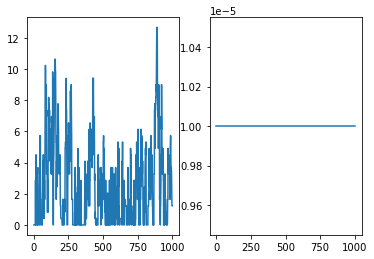

../data/driving_cycles/city\01_FTP72_fuds.mat
maximum steps, simulation is done ... 
elapsed_time: 87.406
Episode: 41 Exploration P: 0.3721 Total reward: -1909.5269167343827 SOC: 0.9373 Cumulative_SOC_deviation: 183.7526 Fuel Consumption: 72.0011

../data/driving_cycles/city\06_udds_truck.mat
maximum steps, simulation is done ... 
elapsed_time: 67.562
Episode: 42 Exploration P: 0.3645 Total reward: -1566.5265523621683 SOC: 0.8175 Cumulative_SOC_deviation: 150.4506 Fuel Consumption: 62.0209

../data/driving_cycles/city\07_manhattan.mat
maximum steps, simulation is done ... 
elapsed_time: 68.288
Episode: 43 Exploration P: 0.3569 Total reward: -2796.050980426396 SOC: 1.0000 Cumulative_SOC_deviation: 275.2179 Fuel Consumption: 43.8715

../data/driving_cycles/city\FTP_75_cycle.mat
maximum steps, simulation is done ... 
elapsed_time: 120.046
Episode: 44 Exploration P: 0.3441 Total reward: -2384.7083272327236 SOC: 0.8091 Cumulative_SOC_deviation: 229.3738 Fuel Consumption: 90.9701

../data/dr

C:\Users\sepri\Desktop\song\experiment\generalization_final\vehicle_model_variant.py:253: RuntimeWarning: invalid value encountered in double_scalars
  del_i = (1 / (2 * r_cha)) * (v_cha - (v_cha ** 2 - 4 * r_cha * p_bat) ** (0.5)) * (p_bat < 0) + (1 / (
C:\Users\sepri\Desktop\song\experiment\generalization_final\vehicle_model_variant.py:254: RuntimeWarning: invalid value encountered in double_scalars
  2 * r_dis)) * (v_dis - (v_dis ** 2 - 4 * r_dis * p_bat) ** (0.5)) * (p_bat >= 0)


maximum steps, simulation is done ... 
******************* Test is start *****************
Total reward: -1112.6105777176872 SOC: 0.4094 Cumulative_SOC_deviation: 111.2045 Fuel Consumption: 0.5655
******************* Test is done *****************



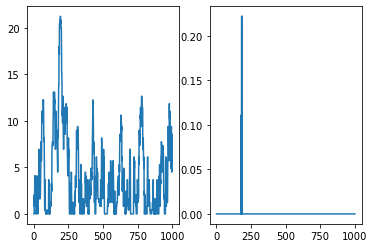

../data/driving_cycles/city\01_FTP72_fuds.mat
maximum steps, simulation is done ... 
elapsed_time: 87.656
Episode: 51 Exploration P: 0.2893 Total reward: -868.5666928326323 SOC: 0.7750 Cumulative_SOC_deviation: 80.8184 Fuel Consumption: 60.3829

../data/driving_cycles/city\06_udds_truck.mat
maximum steps, simulation is done ... 
elapsed_time: 67.666
Episode: 52 Exploration P: 0.2835 Total reward: -906.8097465887641 SOC: 0.6760 Cumulative_SOC_deviation: 85.5427 Fuel Consumption: 51.3829

../data/driving_cycles/city\07_manhattan.mat
maximum steps, simulation is done ... 
elapsed_time: 69.742
Episode: 53 Exploration P: 0.2776 Total reward: -2555.547906839838 SOC: 1.0000 Cumulative_SOC_deviation: 251.5019 Fuel Consumption: 40.5284

../data/driving_cycles/city\FTP_75_cycle.mat
maximum steps, simulation is done ... 
elapsed_time: 117.309
Episode: 54 Exploration P: 0.2677 Total reward: -1456.5821804814802 SOC: 0.6814 Cumulative_SOC_deviation: 137.4372 Fuel Consumption: 82.2100

../data/drivin

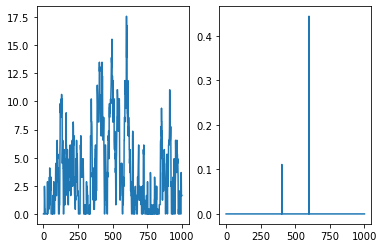

../data/driving_cycles/city\01_FTP72_fuds.mat
maximum steps, simulation is done ... 
elapsed_time: 87.915
Episode: 61 Exploration P: 0.2255 Total reward: -897.6868212799948 SOC: 0.6324 Cumulative_SOC_deviation: 84.7849 Fuel Consumption: 49.8378

../data/driving_cycles/city\06_udds_truck.mat
maximum steps, simulation is done ... 
elapsed_time: 67.174
Episode: 62 Exploration P: 0.2210 Total reward: -1275.6448816242175 SOC: 0.4222 Cumulative_SOC_deviation: 124.2680 Fuel Consumption: 32.9650

../data/driving_cycles/city\07_manhattan.mat
maximum steps, simulation is done ... 
elapsed_time: 69.431
Episode: 63 Exploration P: 0.2164 Total reward: -1692.5187641029959 SOC: 0.9203 Cumulative_SOC_deviation: 165.8811 Fuel Consumption: 33.7082

../data/driving_cycles/city\FTP_75_cycle.mat
maximum steps, simulation is done ... 
elapsed_time: 118.444
Episode: 64 Exploration P: 0.2088 Total reward: -2193.145971983853 SOC: 0.3642 Cumulative_SOC_deviation: 213.4503 Fuel Consumption: 58.6433

../data/driv

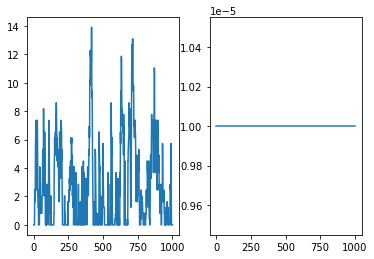

../data/driving_cycles/city\01_FTP72_fuds.mat
maximum steps, simulation is done ... 
elapsed_time: 87.213
Episode: 71 Exploration P: 0.1762 Total reward: -2252.47316563865 SOC: 0.4690 Cumulative_SOC_deviation: 221.5017 Fuel Consumption: 37.4560

../data/driving_cycles/city\06_udds_truck.mat
maximum steps, simulation is done ... 
elapsed_time: 67.583
Episode: 72 Exploration P: 0.1727 Total reward: -1199.3589549840358 SOC: 0.3767 Cumulative_SOC_deviation: 117.0346 Fuel Consumption: 29.0132

../data/driving_cycles/city\07_manhattan.mat
maximum steps, simulation is done ... 
elapsed_time: 69.671
Episode: 73 Exploration P: 0.1692 Total reward: -1457.5814541360621 SOC: 0.8510 Cumulative_SOC_deviation: 142.9228 Fuel Consumption: 28.3530

../data/driving_cycles/city\FTP_75_cycle.mat
maximum steps, simulation is done ... 
elapsed_time: 117.656
Episode: 74 Exploration P: 0.1634 Total reward: -4204.536955033341 SOC: 0.1446 Cumulative_SOC_deviation: 416.0174 Fuel Consumption: 44.3630

../data/driv

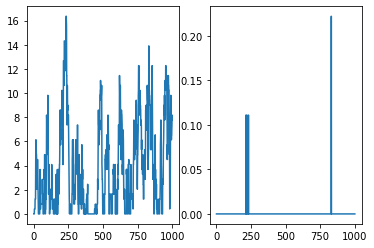

../data/driving_cycles/city\01_FTP72_fuds.mat
maximum steps, simulation is done ... 
elapsed_time: 87.589
Episode: 81 Exploration P: 0.1382 Total reward: -2369.6296135152907 SOC: 0.3890 Cumulative_SOC_deviation: 233.8210 Fuel Consumption: 31.4199

../data/driving_cycles/city\06_udds_truck.mat
maximum steps, simulation is done ... 
elapsed_time: 68.299
Episode: 82 Exploration P: 0.1355 Total reward: -1576.362668519247 SOC: 0.2330 Cumulative_SOC_deviation: 155.7172 Fuel Consumption: 19.1903

../data/driving_cycles/city\07_manhattan.mat
maximum steps, simulation is done ... 
elapsed_time: 71.490
Episode: 83 Exploration P: 0.1328 Total reward: -1072.6329984284725 SOC: 0.7759 Cumulative_SOC_deviation: 105.0337 Fuel Consumption: 22.2963

../data/driving_cycles/city\FTP_75_cycle.mat
maximum steps, simulation is done ... 
elapsed_time: 119.655
Episode: 84 Exploration P: 0.1283 Total reward: -4546.00243846577 SOC: 0.1083 Cumulative_SOC_deviation: 450.5117 Fuel Consumption: 40.8858

../data/driv

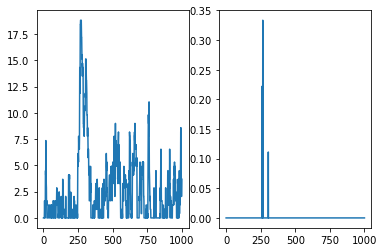

../data/driving_cycles/city\01_FTP72_fuds.mat
maximum steps, simulation is done ... 
elapsed_time: 88.494
Episode: 91 Exploration P: 0.1089 Total reward: -2885.146900937306 SOC: 0.3339 Cumulative_SOC_deviation: 285.7297 Fuel Consumption: 27.8498

../data/driving_cycles/city\06_udds_truck.mat
maximum steps, simulation is done ... 
elapsed_time: 68.442
Episode: 92 Exploration P: 0.1068 Total reward: -1535.931095107558 SOC: 0.3855 Cumulative_SOC_deviation: 150.4873 Fuel Consumption: 31.0584

../data/driving_cycles/city\07_manhattan.mat
maximum steps, simulation is done ... 
elapsed_time: 69.138
Episode: 93 Exploration P: 0.1047 Total reward: -738.7926777208467 SOC: 0.7160 Cumulative_SOC_deviation: 72.1117 Fuel Consumption: 17.6761

../data/driving_cycles/city\FTP_75_cycle.mat
maximum steps, simulation is done ... 
elapsed_time: 120.455
Episode: 94 Exploration P: 0.1013 Total reward: -246.75497170784672 SOC: 0.6160 Cumulative_SOC_deviation: 17.6381 Fuel Consumption: 70.3741

../data/drivin

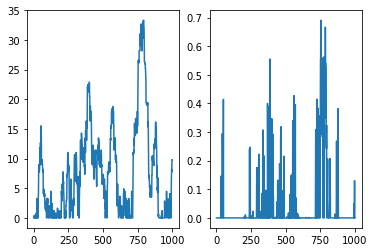

../data/driving_cycles/city\01_FTP72_fuds.mat
maximum steps, simulation is done ... 
elapsed_time: 87.288
Episode: 101 Exploration P: 0.0863 Total reward: -195.38226600641786 SOC: 0.5975 Cumulative_SOC_deviation: 15.3084 Fuel Consumption: 42.2979

../data/driving_cycles/city\06_udds_truck.mat
maximum steps, simulation is done ... 
elapsed_time: 68.260
Episode: 102 Exploration P: 0.0847 Total reward: -134.8461808087936 SOC: 0.6283 Cumulative_SOC_deviation: 9.2231 Fuel Consumption: 42.6150

../data/driving_cycles/city\07_manhattan.mat
maximum steps, simulation is done ... 
elapsed_time: 70.131
Episode: 103 Exploration P: 0.0831 Total reward: -290.6933901920194 SOC: 0.6313 Cumulative_SOC_deviation: 27.9405 Fuel Consumption: 11.2882

../data/driving_cycles/city\FTP_75_cycle.mat
maximum steps, simulation is done ... 
elapsed_time: 120.591
Episode: 104 Exploration P: 0.0804 Total reward: -294.6577725118246 SOC: 0.5934 Cumulative_SOC_deviation: 22.6440 Fuel Consumption: 68.2182

../data/drivi

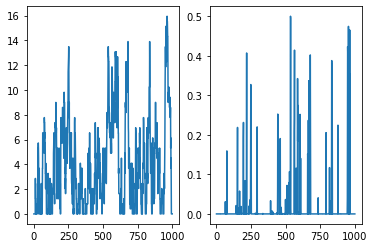

../data/driving_cycles/city\01_FTP72_fuds.mat
maximum steps, simulation is done ... 
elapsed_time: 88.099
Episode: 111 Exploration P: 0.0689 Total reward: -151.37452208489614 SOC: 0.6136 Cumulative_SOC_deviation: 10.8829 Fuel Consumption: 42.5458

../data/driving_cycles/city\06_udds_truck.mat
maximum steps, simulation is done ... 
elapsed_time: 68.367
Episode: 112 Exploration P: 0.0676 Total reward: -123.08747653471717 SOC: 0.6220 Cumulative_SOC_deviation: 8.2485 Fuel Consumption: 40.6028

../data/driving_cycles/city\07_manhattan.mat
maximum steps, simulation is done ... 
elapsed_time: 68.412
Episode: 113 Exploration P: 0.0664 Total reward: -170.1824196248319 SOC: 0.6252 Cumulative_SOC_deviation: 15.9454 Fuel Consumption: 10.7285

../data/driving_cycles/city\FTP_75_cycle.mat
maximum steps, simulation is done ... 
elapsed_time: 119.904
Episode: 114 Exploration P: 0.0643 Total reward: -144.94297440262383 SOC: 0.6093 Cumulative_SOC_deviation: 7.8584 Fuel Consumption: 66.3587

../data/driv

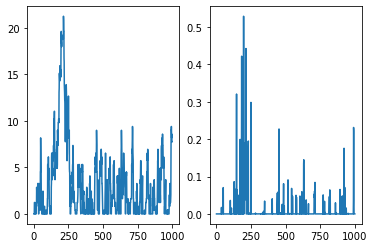

../data/driving_cycles/city\01_FTP72_fuds.mat
maximum steps, simulation is done ... 
elapsed_time: 88.357
Episode: 121 Exploration P: 0.0554 Total reward: -91.37188552230171 SOC: 0.6063 Cumulative_SOC_deviation: 5.0549 Fuel Consumption: 40.8233

../data/driving_cycles/city\06_udds_truck.mat
maximum steps, simulation is done ... 
elapsed_time: 68.125
Episode: 122 Exploration P: 0.0544 Total reward: -148.20295151020213 SOC: 0.6151 Cumulative_SOC_deviation: 10.7991 Fuel Consumption: 40.2115

../data/driving_cycles/city\07_manhattan.mat
maximum steps, simulation is done ... 
elapsed_time: 68.794
Episode: 123 Exploration P: 0.0535 Total reward: -64.31465393253954 SOC: 0.6107 Cumulative_SOC_deviation: 5.4845 Fuel Consumption: 9.4696

../data/driving_cycles/city\FTP_75_cycle.mat
maximum steps, simulation is done ... 
elapsed_time: 118.894
Episode: 124 Exploration P: 0.0519 Total reward: -133.58893108479245 SOC: 0.6060 Cumulative_SOC_deviation: 6.7839 Fuel Consumption: 65.7497

../data/driving

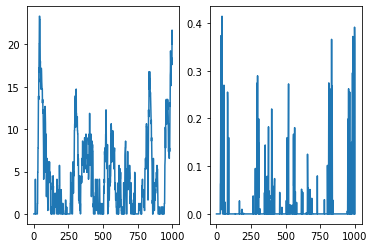

../data/driving_cycles/city\01_FTP72_fuds.mat
maximum steps, simulation is done ... 
elapsed_time: 87.748
Episode: 131 Exploration P: 0.0450 Total reward: -100.01630307476495 SOC: 0.5983 Cumulative_SOC_deviation: 5.9883 Fuel Consumption: 40.1329

../data/driving_cycles/city\06_udds_truck.mat
maximum steps, simulation is done ... 
elapsed_time: 66.896
Episode: 132 Exploration P: 0.0443 Total reward: -118.37983689514147 SOC: 0.6123 Cumulative_SOC_deviation: 7.8795 Fuel Consumption: 39.5852

../data/driving_cycles/city\07_manhattan.mat
maximum steps, simulation is done ... 
elapsed_time: 69.220
Episode: 133 Exploration P: 0.0435 Total reward: -79.54330585072589 SOC: 0.6191 Cumulative_SOC_deviation: 6.9318 Fuel Consumption: 10.2248

../data/driving_cycles/city\FTP_75_cycle.mat
maximum steps, simulation is done ... 
elapsed_time: 120.376
Episode: 134 Exploration P: 0.0423 Total reward: -147.62795290811036 SOC: 0.6040 Cumulative_SOC_deviation: 8.2864 Fuel Consumption: 64.7636

../data/drivin

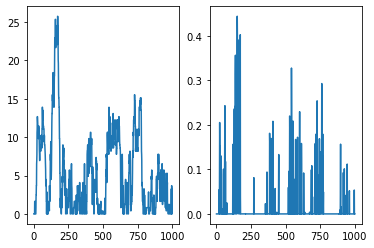

../data/driving_cycles/city\01_FTP72_fuds.mat
maximum steps, simulation is done ... 
elapsed_time: 88.003
Episode: 141 Exploration P: 0.0370 Total reward: -113.83856721083914 SOC: 0.5981 Cumulative_SOC_deviation: 7.3600 Fuel Consumption: 40.2387

../data/driving_cycles/city\06_udds_truck.mat
maximum steps, simulation is done ... 
elapsed_time: 67.881
Episode: 142 Exploration P: 0.0364 Total reward: -111.95843311333427 SOC: 0.6060 Cumulative_SOC_deviation: 7.2889 Fuel Consumption: 39.0692

../data/driving_cycles/city\07_manhattan.mat
maximum steps, simulation is done ... 
elapsed_time: 69.768
Episode: 143 Exploration P: 0.0359 Total reward: -32.017582656584906 SOC: 0.5936 Cumulative_SOC_deviation: 2.4182 Fuel Consumption: 7.8353

../data/driving_cycles/city\FTP_75_cycle.mat
maximum steps, simulation is done ... 
elapsed_time: 120.314
Episode: 144 Exploration P: 0.0349 Total reward: -169.388715225429 SOC: 0.6038 Cumulative_SOC_deviation: 10.4460 Fuel Consumption: 64.9283

../data/driving

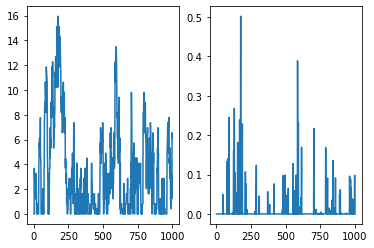

../data/driving_cycles/city\01_FTP72_fuds.mat
maximum steps, simulation is done ... 
elapsed_time: 88.163
Episode: 151 Exploration P: 0.0308 Total reward: -134.59217372030471 SOC: 0.5952 Cumulative_SOC_deviation: 9.4468 Fuel Consumption: 40.1244

../data/driving_cycles/city\06_udds_truck.mat
maximum steps, simulation is done ... 
elapsed_time: 68.113
Episode: 152 Exploration P: 0.0304 Total reward: -106.16515430765735 SOC: 0.6083 Cumulative_SOC_deviation: 6.7026 Fuel Consumption: 39.1393

../data/driving_cycles/city\07_manhattan.mat
maximum steps, simulation is done ... 
elapsed_time: 70.317
Episode: 153 Exploration P: 0.0300 Total reward: -42.31600859472031 SOC: 0.5967 Cumulative_SOC_deviation: 3.4239 Fuel Consumption: 8.0766

../data/driving_cycles/city\FTP_75_cycle.mat
maximum steps, simulation is done ... 
elapsed_time: 120.321
Episode: 154 Exploration P: 0.0292 Total reward: -216.754230633103 SOC: 0.5987 Cumulative_SOC_deviation: 15.2585 Fuel Consumption: 64.1688

../data/driving_

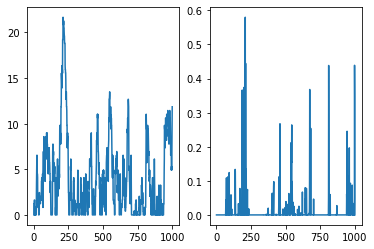

../data/driving_cycles/city\01_FTP72_fuds.mat
maximum steps, simulation is done ... 
elapsed_time: 88.020
Episode: 161 Exploration P: 0.0261 Total reward: -176.3434032012577 SOC: 0.5910 Cumulative_SOC_deviation: 13.7525 Fuel Consumption: 38.8183

../data/driving_cycles/city\06_udds_truck.mat
maximum steps, simulation is done ... 
elapsed_time: 66.724
Episode: 162 Exploration P: 0.0257 Total reward: -115.25010346253595 SOC: 0.5988 Cumulative_SOC_deviation: 7.7092 Fuel Consumption: 38.1580

../data/driving_cycles/city\07_manhattan.mat
maximum steps, simulation is done ... 
elapsed_time: 68.604
Episode: 163 Exploration P: 0.0254 Total reward: -91.31592412425037 SOC: 0.5910 Cumulative_SOC_deviation: 8.3583 Fuel Consumption: 7.7325

../data/driving_cycles/city\FTP_75_cycle.mat
maximum steps, simulation is done ... 
elapsed_time: 120.111
Episode: 164 Exploration P: 0.0248 Total reward: -303.49344268689276 SOC: 0.5956 Cumulative_SOC_deviation: 23.9364 Fuel Consumption: 64.1293

../data/drivin

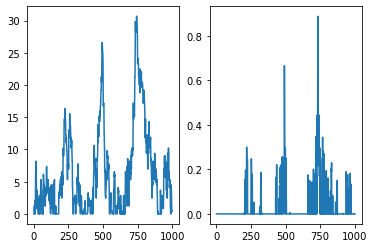

../data/driving_cycles/city\01_FTP72_fuds.mat
maximum steps, simulation is done ... 
elapsed_time: 87.309
Episode: 171 Exploration P: 0.0224 Total reward: -220.20951299491463 SOC: 0.5939 Cumulative_SOC_deviation: 18.0155 Fuel Consumption: 40.0548

../data/driving_cycles/city\06_udds_truck.mat
maximum steps, simulation is done ... 
elapsed_time: 68.112
Episode: 172 Exploration P: 0.0221 Total reward: -133.15944141254965 SOC: 0.5958 Cumulative_SOC_deviation: 9.4666 Fuel Consumption: 38.4933

../data/driving_cycles/city\07_manhattan.mat
maximum steps, simulation is done ... 
elapsed_time: 70.080
Episode: 173 Exploration P: 0.0219 Total reward: -78.38655765307038 SOC: 0.5993 Cumulative_SOC_deviation: 7.0288 Fuel Consumption: 8.0989

../data/driving_cycles/city\FTP_75_cycle.mat
maximum steps, simulation is done ... 
elapsed_time: 120.289
Episode: 174 Exploration P: 0.0214 Total reward: -216.25111594944565 SOC: 0.5975 Cumulative_SOC_deviation: 15.1404 Fuel Consumption: 64.8476

../data/drivi

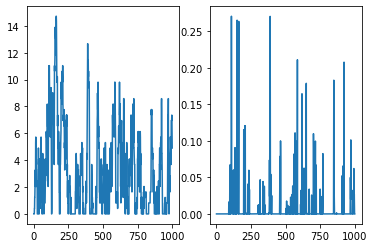

../data/driving_cycles/city\01_FTP72_fuds.mat
maximum steps, simulation is done ... 
elapsed_time: 87.982
Episode: 181 Exploration P: 0.0196 Total reward: -234.3350305292953 SOC: 0.5920 Cumulative_SOC_deviation: 19.4908 Fuel Consumption: 39.4266

../data/driving_cycles/city\06_udds_truck.mat
maximum steps, simulation is done ... 
elapsed_time: 68.378
Episode: 182 Exploration P: 0.0194 Total reward: -162.59704491693316 SOC: 0.5881 Cumulative_SOC_deviation: 12.4814 Fuel Consumption: 37.7835

../data/driving_cycles/city\07_manhattan.mat
maximum steps, simulation is done ... 
elapsed_time: 70.485
Episode: 183 Exploration P: 0.0192 Total reward: -61.84317865977771 SOC: 0.5989 Cumulative_SOC_deviation: 5.3888 Fuel Consumption: 7.9556

../data/driving_cycles/city\FTP_75_cycle.mat
maximum steps, simulation is done ... 
elapsed_time: 120.582
Episode: 184 Exploration P: 0.0188 Total reward: -150.8378776232859 SOC: 0.6009 Cumulative_SOC_deviation: 8.6265 Fuel Consumption: 64.5730

../data/driving

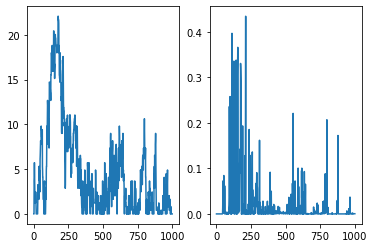

../data/driving_cycles/city\01_FTP72_fuds.mat
maximum steps, simulation is done ... 
elapsed_time: 86.749
Episode: 191 Exploration P: 0.0174 Total reward: -129.1410497063821 SOC: 0.5911 Cumulative_SOC_deviation: 8.9395 Fuel Consumption: 39.7456

../data/driving_cycles/city\06_udds_truck.mat
maximum steps, simulation is done ... 
elapsed_time: 67.636
Episode: 192 Exploration P: 0.0172 Total reward: -89.14205038413814 SOC: 0.6187 Cumulative_SOC_deviation: 4.9000 Fuel Consumption: 40.1419

../data/driving_cycles/city\07_manhattan.mat
maximum steps, simulation is done ... 
elapsed_time: 69.722
Episode: 193 Exploration P: 0.0171 Total reward: -46.85998947873785 SOC: 0.6018 Cumulative_SOC_deviation: 3.8406 Fuel Consumption: 8.4536

../data/driving_cycles/city\FTP_75_cycle.mat
maximum steps, simulation is done ... 
elapsed_time: 118.721
Episode: 194 Exploration P: 0.0168 Total reward: -169.68582594463453 SOC: 0.6029 Cumulative_SOC_deviation: 10.3523 Fuel Consumption: 66.1623

../data/driving_

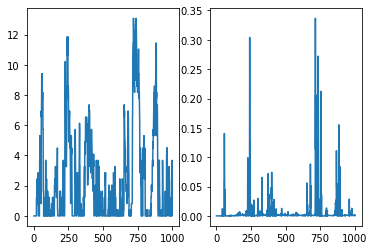

model is saved..


In [15]:
# print(env.version)

num_trials = 1
results_dict = {} 
driving_cycle_paths = glob.glob("../data/driving_cycles/city/*.mat")[:5]

for trial in range(num_trials): 
    print("")
    print("Trial {}".format(trial))
    print("")
    
    actor_model, critic_model, target_actor, target_critic, buffer = initialization()
    
    eps = MAX_EPSILON 
    steps = 0
    
    episode_rewards = [] 
    episode_SOCs = [] 
    episode_FCs = [] 
    episode_test_history = [] 
    episode_num_test = [] 
    for ep in range(total_episodes):
        i = ep % len(driving_cycle_paths)
        driving_cycle_path =driving_cycle_paths[i]
        print(driving_cycle_path)
        drv_cycle = sio.loadmat(driving_cycle_path)
        driving_cycle = drv_cycle["sch_cycle"][:, 1]

        env = initialization_env(driving_cycle, 10)
        
        start = time.time() 
        state = env.reset() 
        episodic_reward = 0 

        while True: 
            tf_state = tf.expand_dims(tf.convert_to_tensor(state), 0)
            action = policy_epsilon_greedy(tf_state, eps)
    #         print(action)
            next_state, reward, done = env.step(action)
            if done: 
                next_state = [0] * num_states 

            buffer.record((state, action, reward, next_state))
            episodic_reward += reward 

            if steps > DELAY_TRAINING: 
                buffer.learn() 
                update_target(tau)
                eps = MIN_EPSILON + (MAX_EPSILON - MIN_EPSILON) * np.exp(-DECAY_RATE * (steps
                                                                        -DELAY_TRAINING))

            steps += 1

            if done: 
                break 

            state = next_state 

        elapsed_time = time.time() - start 
        print("elapsed_time: {:.3f}".format(elapsed_time))
        episode_rewards.append(episodic_reward) 
        episode_SOCs.append(env.SOC)
        episode_FCs.append(env.fuel_consumption) 

    #     print("Episode * {} * Avg Reward is ==> {}".format(ep, avg_reward))
        SOC_deviation_history = np.sum(np.abs(np.array(env.history["SOC"]) - 0.6)) 
        print(
              'Episode: {}'.format(ep + 1),
              "Exploration P: {:.4f}".format(eps),
              'Total reward: {}'.format(episodic_reward), 
              "SOC: {:.4f}".format(env.SOC), 
              "Cumulative_SOC_deviation: {:.4f}".format(SOC_deviation_history), 
              "Fuel Consumption: {:.4f}".format(env.fuel_consumption), 
        )
        print("")
        
        if (ep + 1) % 10 == 0: 
            history = test_agent(actor_model, 10)
            episode_test_history.append(history) 
            episode_num_test.append(ep + 1)
            
    root = "DDPG_reference_trained_variant_five"
    save_weights(actor_model, critic_model, target_actor, target_critic, root)
    
    results_dict[trial + 1] = {
        "rewards": episode_rewards, 
        "SOCs": episode_SOCs, 
        "FCs": episode_FCs, 
        "test_history": episode_test_history, 
        "test_episode_num": episode_num_test, 
    }

In [16]:
with open("DDPG_reference_variant_five.pkl", "wb") as f: 
    pickle.dump(results_dict, f, pickle.HIGHEST_PROTOCOL)

In [17]:
# results_dict